In [120]:
# Imports. Nothing to see here.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string
from pprint import pprint

from imblearn.over_sampling import SMOTE
from gensim.models import Word2Vec
import gensim
from gensim.utils import simple_preprocess
from collections import Counter
import gensim.corpora as corpora

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import random

import sqlite3
from textblob import TextBlob
from wordcloud import WordCloud

from sklearn.cluster import KMeans
import pickle

import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.decomposition import PCA

In [72]:
filtered = pd.read_pickle("./filtered")
data = pd.read_pickle("./data")
filtered

podcast_id                     slug   category  \
12       ad4f2bf69c72b8db75978423c25f379e          ted talks daily       arts   
13       ad4f2bf69c72b8db75978423c25f379e          ted talks daily       arts   
14       ad4f2bf69c72b8db75978423c25f379e          ted talks daily  education   
18       ad4f2bf69c72b8db75978423c25f379e          ted talks daily       arts   
19       ad4f2bf69c72b8db75978423c25f379e          ted talks daily       arts   
...                                   ...                      ...        ...   
1425128  f3c611ee25d6b3f0efca2f2f86fb114b  stolen lives true crime    society   
1425134  bd39dd4c1a5d156af80b8b1ac8a8e50d           sleep whispers    society   
1425135  bd39dd4c1a5d156af80b8b1ac8a8e50d           sleep whispers    society   
1425155  f599da38fa69271b49f2dbbf56686874            conversations    society   
1425163  f9255ade54a8e12df362cde70b49dff9               the trypod     comedy   

                                                   content  rating  \
12                                            [love, good]       5   
13                                            [love, good]       5   
14                                            [love, good]       5   
18       [much, bs, trying, convince, racist, sexist, c...       3   
19       [much, bs, trying, convince, racist, sexist, c...       3   
...                                                    ...     ...   
1425128  [stories, sad, children, need, protected, keep...       5   
1425134  [one, top, asmr, sleep, whisper, podcasts, get...       5   
1425135  [one, top, asmr, sleep, whisper, podcasts, get...       5   
1425155  [richard, engaged, engaging, sarah, k, however...       5   
1425163  [really, crappy, ep, 2, 4, guess, winners, wou...       1   

                                                      lemm  predict  
12                                               love good        4  
13                                               love good        4  
14                                               love good        4  
18       much b trying convince racist sexist country m...        1  
19       much b trying convince racist sexist country m...        1  
...                                                    ...      ...  
1425128  story sad child need protected keep good work ...        3  
1425134  one top asmr sleep whisper podcasts get excite...        1  
1425135  one top asmr sleep whisper podcasts get excite...        1  
1425155  richard engaged engaging sarah k however like ...        4  
1425163  really crappy ep 2 4 guess winner would really...        4  

[249550 rows x 7 columns]

In [39]:
print(filtered.rating.value_counts().sort_index())
print(filtered['predict'].value_counts().sort_index())

1     10991
2      4571
3      5682
4      9713
5    218593
Name: rating, dtype: int64
1     41291
2     30651
3     43421
4    127005
5      7182
Name: predict, dtype: int64


In [40]:
filtered['difference'] = abs(filtered['rating'] - filtered['predict'])

In [41]:
big_diff = filtered[filtered['difference'] >= 2]
big_diff.shape

(106808, 8)

In [42]:
print(big_diff['rating'].value_counts().sort_index())
print(big_diff['predict'].value_counts().sort_index())

1     6175
2      919
3     2251
4     2253
5    95210
Name: rating, dtype: int64
1    39337
2    23973
3    38983
4     2053
5     2462
Name: predict, dtype: int64


# Recommendations

In [43]:
from surprise import Reader, Dataset
from surprise.prediction_algorithms import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.model_selection import train_test_split as tts
from surprise.dataset import DatasetAutoFolds
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import GridSearchCV

In [44]:
tf = pickle.load(open("tf.p", "rb"))

In [45]:
tfidf = TfidfVectorizer()
tf_filter = tfidf.fit_transform(big_diff['lemm'])

In [46]:
clusters = tf.transform(big_diff['lemm'])
kmeans1000 = KMeans(n_clusters=1000, random_state=42, n_init=1, max_iter=3, verbose=3, n_jobs=-1)
kmeans1000.fit(clusters)
big_diff['cluster'] = kmeans1000.predict(clusters)

Initialization complete
Iteration 0, inertia 101672.71891282177
Iteration 1, inertia 97011.51877197041
Iteration 2, inertia 94301.73085425173


In [47]:
# DF must be '[user_id', 'item_id', 'rating'] and nothing else

rec = big_diff[['cluster', 'slug', 'rating']]

reader = Reader(rating_scale=(1, 5))
rec = Dataset.load_from_df(rec, reader)

train, test = train_test_split(rec, test_size=0.2)

In [48]:
model = SVD().fit(train)

In [49]:
predictions = model.test(test)

In [50]:
predictions[0:5]

[Prediction(uid=355, iid='joel osteen podcast', r_ui=1.0, est=2.0133102575115056, details={'was_impossible': False}),
 Prediction(uid=494, iid='unabashed book snobbery', r_ui=5.0, est=4.831077856725837, details={'was_impossible': False}),
 Prediction(uid=34, iid='twenty thousand hertz', r_ui=5.0, est=5, details={'was_impossible': False}),
 Prediction(uid=364, iid='profiles', r_ui=5.0, est=4.784905871152396, details={'was_impossible': False}),
 Prediction(uid=78, iid='absolutely not', r_ui=5.0, est=5, details={'was_impossible': False})]

In [51]:
accuracy.rmse(predictions)

RMSE: 0.9123


0.9122892332079167

In [52]:
from collections import defaultdict

from surprise import SVD
from surprise import Dataset


def get_top_n(predictions, n=5):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

 'the truth about money with ric edelman', 'retirement paradise', 'podcasts marquetta breslin', 'unstoppable success radio', 'pop up film cast', 'wedding planning podcast', 'wedding planning podcast', 'complete marvel reading order podcast']
743 ['who are these podcasts']
91 ['face jam', 'face jam', 'are we there yet moms']
877 ['spiritual monkey podcast', 'other peoples problems', 'puro show', 'lexicon valley', 'lexicon valley', 'livin large with mark dohner']
588 ['the cardone zone', 'the cardone zone', 'wow in the world', 'wow in the world', 'spiraling up', 'story pirates', 'stuff you should know']
758 ['congratulations with chris delia', 'news af internets best news stories that are actual', 'zane and heath unfiltered']
170 ['stay wealthy', 'experts on the wire an seo podcast', 'experts on the wire an seo podcast', 'repurpose your career career pivot careers for 2nd', 'let it out', 'let it out', 'zero to travel podcast', 'zero to travel podcast', 'founders talk', 'onward creatives'

In [53]:
# param_grid = {'n_factors':[39, 40, 42],'n_epochs':[30, 35],  'lr_all':[0.025, 0.03],'reg_all':[0.005, 0.01]}
# gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1, joblib_verbose=3)
# gs.fit(rec)

In [54]:
# gs.best_params, gs.best_score

In [62]:
# grid_svd = SVD(n_factors=42, n_epochs=30, lr_all=0.025, reg_all=0.01)
# grid_svd.fit(train)

In [63]:
# gridsvd_test_preds = grid_svd.test(test)
# accuracy.rmse(gridsvd_test_preds)

RMSE: 0.9374


0.9373568982269778

In [57]:
# Lesson Plan
# grid_svd.predict(133295, 'b09a54d2aa8d816fae4e799319b0cf41', 5)

In [58]:
# filtered.shape

In [59]:
# ###########################
# # This will work but is it what I want?

# kmeansfilter = KMeans(n_clusters=1000, random_state=42, n_init=1, max_iter=3, verbose=3, n_jobs=-1)
# kmeansfilter.fit(tf_filter)

# ###########################

In [60]:
# filterpredict = kmeansfilter.predict(kmeansfilter)

In [61]:
# gridsvd_test_preds

In [85]:
datanot5

podcast_id                  slug   category  \
6        ad4f2bf69c72b8db75978423c25f379e       ted talks daily       arts   
7        ad4f2bf69c72b8db75978423c25f379e       ted talks daily       arts   
8        ad4f2bf69c72b8db75978423c25f379e       ted talks daily  education   
15       ad4f2bf69c72b8db75978423c25f379e       ted talks daily       arts   
16       ad4f2bf69c72b8db75978423c25f379e       ted talks daily       arts   
...                                   ...                   ...        ...   
1425129  dfb10d1e367d811020548db40795b60f    the boogie monster     comedy   
1425132  d1c2ee274bcf6188e5b6202fb1273452  the dave ramsey show   business   
1425133  d1c2ee274bcf6188e5b6202fb1273452  the dave ramsey show   business   
1425162  f9255ade54a8e12df362cde70b49dff9            the trypod     comedy   
1425163  f9255ade54a8e12df362cde70b49dff9            the trypod     comedy   

                                                   content  rating  \
6        [liberal, pretty, obvious, annoying, trying, p...       1   
7        [liberal, pretty, obvious, annoying, trying, p...       1   
8        [liberal, pretty, obvious, annoying, trying, p...       1   
15       [listened, spanish, flu, pod, cast, 20, minute...       1   
16       [listened, spanish, flu, pod, cast, 20, minute...       1   
...                                                    ...     ...   
1425129  [one, favorite, podcasts, started, focusing, p...       1   
1425132  [guys, financial, experts, advise, financial, ...       1   
1425133  [guys, financial, experts, advise, financial, ...       1   
1425162  [well, sit, us, turned, 30, minutes, actual, c...       1   
1425163  [really, crappy, ep, 2, 4, guess, winners, wou...       1   

                                                      lemm  polarity  \
6        liberal pretty obvious annoying trying push be... -0.110000   
7        liberal pretty obvious annoying trying push be... -0.110000   
8        liberal pretty obvious annoying trying push be... -0.110000   
15       listened spanish flu pod cast 20 minute hour l... -0.124098   
16       listened spanish flu pod cast 20 minute hour l... -0.124098   
...                                                    ...       ...   
1425129    one favorite podcasts started focusing politics  0.500000   
1425132  guy financial expert advise financial matter l...  0.000000   
1425133  guy financial expert advise financial matter l...  0.000000   
1425162  well sit u turned 30 minute actual content 25 ... -0.100000   
1425163  really crappy ep 2 4 guess winner would really...  0.155363   

         subjectivity  predict  
6            0.500000        1  
7            0.500000        1  
8            0.500000        1  
15           0.274170        1  
16           0.274170        1  
...               ...      ...  
1425129      1.000000        1  
1425132      0.000000        1  
1425133      0.000000        1  
1425162      0.250000        1  
1425163      0.470611        4  

[156437 rows x 9 columns]

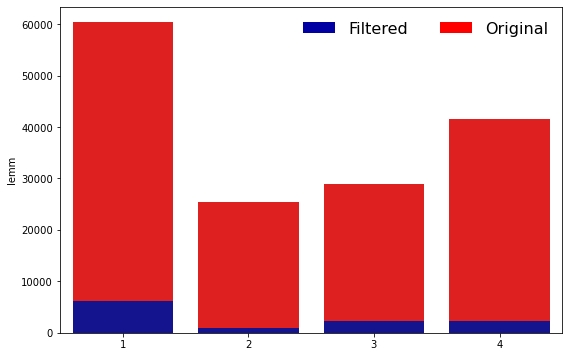

In [97]:
plt.figure(figsize=(9,6))

datanot5 = data[data['rating'] < 5]
big_diffnot5 = big_diff[big_diff['rating']<5]

#Plot 1 - background - "total" (top) series
sns.barplot(x = [1,2,3,4], y = datanot5.groupby('rating')['lemm'].count(), color = "red")

#Plot 2 - overlay - "bottom" series
sns.barplot(x = [1,2,3,4], y = big_diffnot5.groupby('rating')['lemm'].count(), color = "#0000A3")

topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Filtered', 'Original'], loc=1, ncol = 2, prop={'size':16})
l.draw_frame(False)

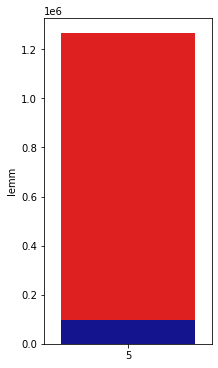

In [98]:
plt.figure(figsize=(3,6))
data5 = data[data['rating'] == 5]
big_diff5 = big_diff[big_diff['rating']==5]

#Plot 1 - background - "total" (top) series
sns.barplot(x = [5], y = data5.groupby('rating')['lemm'].count(), color = "red")

#Plot 2 - overlay - "bottom" series
sns.barplot(x = [5], y = big_diff5.groupby('rating')['lemm'].count(), color = "#0000A3")

topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')

In [69]:
big_diff.groupby('rating')['lemm'].count()

rating
1     6175
2      919
3     2251
4     2253
5    95210
Name: lemm, dtype: int64

In [118]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
stop_words = stopwords.words('english')
datum = big_diff.lemm.values.tolist()
data_words = list(sent_to_words(datum))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

['much', 'trying', 'convince', 'racist', 'sexist', 'country', 'much', 'privilege', 'time', 'move']
[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]


In [130]:
# number of topics
num_topics = 200
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

C:\Users\tcmca\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

[(22,
  '0.020*"like" + 0.013*"episode" + 0.013*"one" + 0.011*"show" + 0.011*"story" '
  '+ 0.010*"people" + 0.010*"great" + 0.008*"love" + 0.007*"talk" + '
  '0.007*"make"'),
 (21,
  '0.016*"like" + 0.012*"episode" + 0.011*"get" + 0.010*"love" + 0.009*"time" '
  '+ 0.009*"one" + 0.008*"really" + 0.008*"make" + 0.008*"thing" + '
  '0.008*"always"'),
 (66,
  '0.016*"god" + 0.013*"one" + 0.012*"need" + 0.011*"like" + 0.011*"really" + '
  '0.009*"good" + 0.009*"lie" + 0.007*"see" + 0.007*"episode" + 0.007*"word"'),
 (122,
  '0.018*"episode" + 0.012*"get" + 0.011*"people" + 0.011*"love" + '
  '0.010*"podcasts" + 0.010*"one" + 0.008*"show" + 0.008*"time" + '
  '0.00

In [132]:
import pyLDAvis.gensim
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

C:\Users\tcmca\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

